In [1]:
#import theano 
from scipy.integrate import odeint
import math 
import numpy as np
import theano 
from theano import *
import matplotlib.pyplot as plt

%matplotlib inline

theano.config.exception_verbosity= 'high'
THEANO_FLAGS='optimizer=fast_compile'

#  Forward model using scipy odeint

In this example we'll use a model of a reversible chemical reaction:

$$\dot{y}(t) = k_1 (1 - y) - k_2 y,$$

where $k_1$ represents a forward reaction rate, $k_2$ is the backward reaction rate, and $y$ represents the concentration of a chemical solute.

Next, we write Python functions to solve this ODE and call up the forward solution for a given set of parameters. Note that the r.h.s constitute of the governing equation plus couple of more states. Solution of these extra states gives us the sensitivities $\frac{dy}{dk_{j}}(t)$, that is the rate of change of the state w.r.t the parameters. We need these quantities later to embed this ODE within Theano.

In [2]:
def model_deriv(y, t, param):
    #Define parameters
    k1,k2=param
    #print(param)
    #define states
    #V,dV_da,dV_db=y
    Y,dY_dk1,dY_dk2=y
    #define derivatives
    dy_dt=k1 * (1 - Y) - k2 * Y
    #define sensitivity odes
    dy_dk1_dt=-(k1+k2)*dY_dk1 + (1-Y)
    dy_dk2_dt=-(k1+k2)*dY_dk2 - Y
    
    
    return dy_dt,dy_dk1_dt,dy_dk2_dt

def model_sol(param):
    
    y0 = [0.1,0,0]
    time = np.linspace(0, 2, 40)
    solution = odeint(model_deriv, y0, time, args=(param,))
    return np.array(solution)

#  Generate an artificial dataset

We add random noise $\mathcal{N}(0,0.05)$ to the ODE solution to generate the artificial dataset.

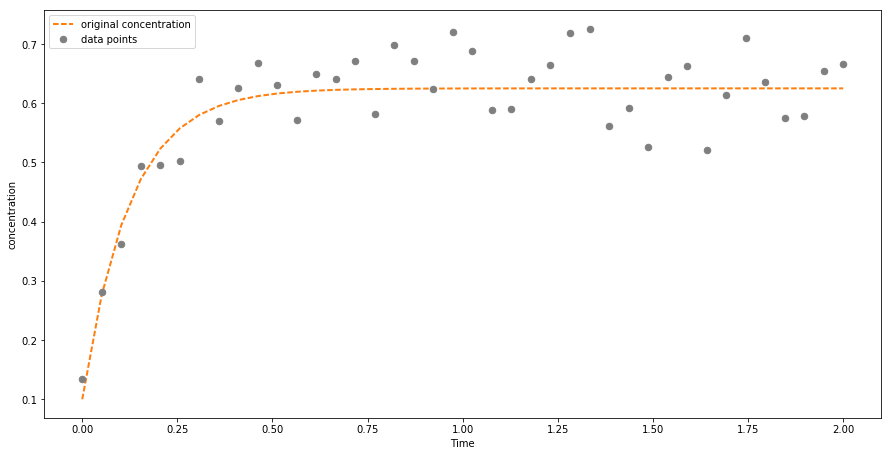

In [3]:
times = np.linspace(0, 2, 40)
sol=model_sol([5.,3.])
true_sol=sol[:,0]
sigma=0.05
Y=true_sol + np.random.randn(40)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, true_sol, '--', color='#ff7f0e', lw=2, label='original concentration')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('concentration')

# The inverse problem

Given some experimental data, which we have artificially generated, $Y$ we want to infer the posterior distribution of parameters $p(k_1,k_2|Y)$



#  Can we AutoDiff a mechanistic model? 

In the Fitzhugh Nagumo example we have seen how easy it is to implement the forward model as a Theano `as_op@`. However, one limitation of that approach is that the op becomes non-differentiable. As a result we cannot use that op to run the NUTS sampler or for that matter any sampler that uses the gradient of the target distribution, in our case the posterior. Now the cool thing about an automatic differentiation package is that as long as you can write the entire generative model using such packages you can differentiate layer by layer (as in a deep net) using the chain rule. Basically the Backprop algorithm. PyMC3 and others (Edward, Pyro) gives you a set of differentiable density functions, plus you can define any deterministic maps using Theano (TensorFlow, PyTorch etc). Thus once you compose a model the underlying autodiff takes care of finding the gradient of the target density. This is so cool that now you can compose models with desnities, non-liear maps, invertible transforms and let the package take care of the inference bit. So if you are a modeller then you can create beautifully detailed model with arbitary complexities and carry out inference with a button press !

A fundamental assumption behind autodiff is that all the functions are analytically tractable and thus you can write down everything symbolically. Sadly ! an ODE solution cannot be written down symbolically and you have to use a numerical method to approximate the solution. This is true for all of mechanistic modelling.

So then how can we use probabilistic programming for inverse problems and use the benefits associated with layer-wise differentiating?

This is what we would develop in the following. The coolest bit is that the strategy I am going to show you is universal. Thus this can be easily extended to other autodiff packages and ppls built on top of them.

#  The sensitivity matrix

For our single state logistic ODE the sensitivity matrix is given as

$$ S_{i,j} = \frac{dy(t_i)}{dk_{j}},$$ basically each column is the sensitivty vector w.r.t each parameter. Thus if we have $d$ parameters and we solve the ODE at $T$ time points then we have a $T \times d$ matrix. Now how is this helpful? To answer this question let us consider the likelihood of our model:
$$ \mathcal{L}(\theta)=\mathcal{N}(Y|y(t,\theta),\sigma^2),$$ where $Y$ is the noisy observation (that we have generated), $y(t,\theta)$ is the logistic ODE solution and we collected the paramters as $\theta=(k_1,k_2)$. Now if we want to differentiate $\mathcal{L}$ w.r.t $\theta$ we can simple apply the chain rule:
$$\frac{d\mathcal{L}(\theta)}{d\theta}=\frac{d\mathcal{N}(Y|y(t,\theta),\sigma^2)}{dy(t,\theta)}^T\cdot
\frac{dy(t,\theta)}{d\theta}=\frac{d\mathcal{N}(Y|y(t,\theta),\sigma^2)}{dy(t,\theta)}^T\cdot S,
$$ where $S$ is the sensitivity matrix we defined before. This product of a vector with a jacobian matrix is known as the vector-Jacobian (vjp) product in autodiff parlance.

If we have a analytical non-linear relationship between $\theta$ and $y(t,\theta)$ such as say $y=\theta^2$, or for example any non-linearity used in a neural network rather than our ODE, then the vjp would have been efficiently evaluated by the autodiff software by using reverse mode auto-differenciation. But for any ODE this is something we have to do ourselves.
Now if we look carefully the first term in the vjp is analytic (this is the case for other standard densities) and thus any autodiff package can handle that. Thus our ODE layer with a custom op needs to evaluate the forward solution $y(t,\theta)$ and when it receives the gradient of the target function w.r.t its output (the first term in our likelihood gradient) then it needs to evaluate the vjp numerically. This can be easily implemented in Theano or other autodiff packages. Moreover, we do not need to write the numerical solution in Theano. This is extremely usefull as in our approach one can use a high performance solver (written in C/C++) without changing anything. The solver needs to either be wrapped in Python or, for more efficiency, the entire custom op can be written in C.

#  Define a custom Theano op with grad 

These ops that we define here are model (ODE) agnostic. they can be used for any ODE system, so it is almost like a boilerplate code (depending on the paramter passing, I'll elaborate that later). Basically we write one op `ODEop` that calls an underlying python (or wrapper) ODE solver and generates the model solution as a tensor variable. While evaluating the gradient it uses another op `ODEGradop` which outputs the vjp. The actual ODE solution and vjp is handled numerically in python by the functions `state` and `jac_sens`. We pass these functions to the Theano op.  


In [4]:
class ODEGradop(theano.Op):
    def __init__(self,jac_sens):
        self.jac_sens = jac_sens

    def make_node(self, x, v):
        x = theano.tensor.as_tensor_variable(x)

        v = theano.tensor.as_tensor_variable(v)
        node = theano.Apply(self, [x, v], [v.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        v = inputs_storage[1]
        out = output_storage[0]
        out[0] = np.asarray(self.jac_sens(x, v))
        
class ODEop(theano.Op):

    def __init__(self, state, jac_sens):
        self.state = state
        self.jac_sens =jac_sens

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        
        out[0] = np.asarray(self.state(x))

    def grad(self, inputs, output_grads):
        x = inputs[0]
        v = output_grads[0]
        op = self

        grad_op = ODEGradop(self.jac_sens)
        grad_op_apply = grad_op(x, v)
        
        return [grad_op_apply]

#  Define functions that collects the ODE state and sensitivity  

The following two functions call the forward model (scipy odeint) and respectively passes the state and vjp as part of the backprop algorithm. These functions are then called within our new Theano ops defined previously. 


In [5]:
def state(x):
    sol = model_sol(np.array(x))
    return sol[:,0]
def jac_sens(x, v):
    sol = model_sol(np.array(x))
    return sol[:,-2:].T.dot(v)


# Alternatives to a Python op

Note that this approach's limitation is the python-Theano (and C after compilation of the graph) communication. ALternatively we can write an ODE solver completely in Theano, say the Runge Kutta solver or BDF for stiff ODE. That way all parts of the graph would be Theano based and would be computationally better performing than what we have done here. However, writting a solver from scratch in Theano is kind of like re-inventing the wheel. I believe a better option is to write the custom op in C (All autodiffs allow C/C++ ops). That way we can use many legacy solvers easyily for our purpose. However, I have not explored these avenues.

#  Define the probabilistic program

Next we define the PyMC3 model, setup the NUTS sampler and press the inference button. 

In [11]:
import pymc3 as pm
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'ignore'

Logistic_ODEop = ODEop(state, jac_sens)

with pm.Model() as Logistic_model:
    # We place Uniform priors on the two model parameters
    theta = pm.Uniform('theta', lower=1, upper=10, shape=2)
    
    # Here we call the forward model
    forward=Logistic_ODEop(theta)
    
    # We place Half-Normal prior on the noise parameter
    sigma = pm.HalfNormal('sigma', sd=0.1)
    
    # The likelihood is Gaussian
    y=pm.Normal('y', mu=forward, sd=sigma, observed=Y)
    
    # Sample using NUTS basic mode
    start={'theta':np.array([2.,2.])}
    trace = pm.sample(5000, chains=1, tune=2000, start=start)
    

100%|██████████| 7000/7000 [02:41<00:00, 43.47it/s]


#  Visualising the posterior approximation



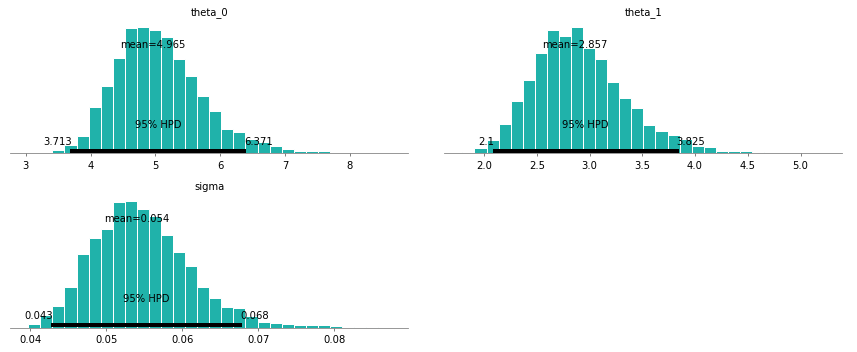

In [12]:
pm.plot_posterior(trace, color='LightSeaGreen');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdb8aceb10>,
      dtype=object)

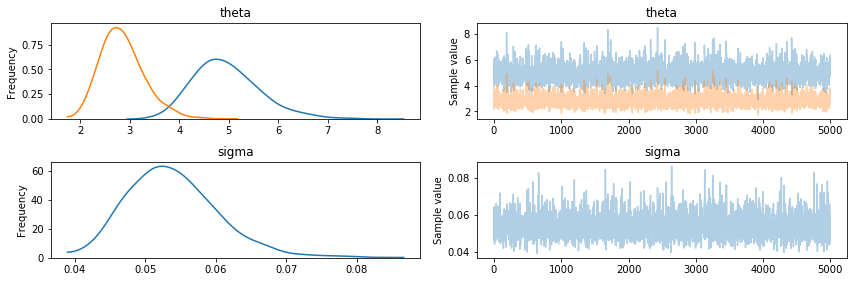

In [13]:
pm.traceplot(trace)

In [14]:
pm.summary(trace) #Note we need multiple chains for RHat, see tutorial on Lotka Volterra

,mean,sd,mc_error,hpd_2.5,hpd_97.5
theta__0,4.964743,0.686171,0.015730,3.713164,6.370614
theta__1,2.856948,0.452796,0.010266,2.099954,3.824746
sigma,0.053986,0.006526,0.000149,0.042985,0.067632


#  Posterior predictive plots

Draw $500$ samples of the state as the posterior predictive

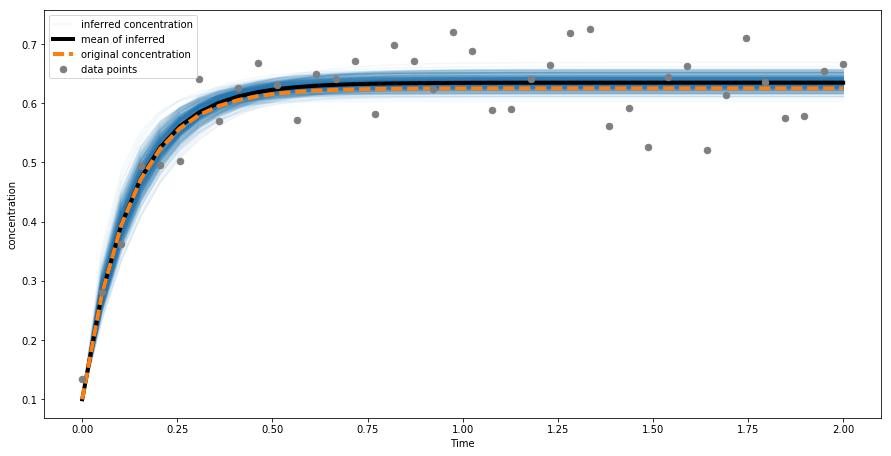

In [15]:
params=trace['theta']
params.shape
new_values = []
for ind in range(500):
    ppc_sol=model_sol(params[ind])
    new_values.append(ppc_sol[:,0])
new_values = np.array(new_values)
mean_values = np.mean(new_values, axis=0)
new_values.shape
plt.figure(figsize=(15, 7.5))
plt.plot(times, new_values[0], color='#1f77b4', alpha=0.05, label='inferred concentration')
for v in new_values[1:]:
    plt.plot(times, v, color='#1f77b4', alpha=0.05)
plt.plot(times, mean_values, color='black', lw=4, label='mean of inferred')
plt.plot(times, true_sol, '--', color='#ff7f0e', lw=4, label='original concentration')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('concentration')
